#Exploring methods to minimize training data size while maintaining maximum model accuracy.

I am using the MNIST dataset and sklearn's MLP classifier to easily test these methods before transfering to chemprop.

In [ ]:
from torchvision import datasets

training = datasets.MNIST(root = '.',
                          train = True,
                          download = True
                          )
data = training.data.numpy()
labels = training.targets.numpy()

data = data.reshape(60000, 784)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Of the 60k images, split into 48k training set and 12k testing set.

In [ ]:
from sklearn.model_selection import train_test_split
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(data, labels, train_size = 0.80, random_state=0)

Model training with full training data set to establish a baseline.

In [ ]:
import time
from sklearn.neural_network import MLPClassifier

start = time.time()
clf = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (100, 100), random_state = 0)
clf.fit(x_train_full, y_train_full)
full_training_score = clf.score(x_test_full, y_test_full)
end = time.time()
print("Full training set score", full_training_score)
seconds = end - start
print("Runtime: %2dm%2ds" % (seconds / 60, seconds % 60))

Full training set score 0.9615
Runtime:  5m19s


Model training with first 10k training samples.

In [ ]:
import time
from sklearn.neural_network import MLPClassifier

start = time.time()
clf = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (100, 100), random_state = 0)
clf.fit(x_train_full[:10000], y_train_full[:10000])
random_10k_training_score = clf.score(x_test_full, y_test_full)
end = time.time()
print("Full training set score", full_training_score)
seconds = end - start
print("Runtime: %2dm%2ds" % (seconds / 60, seconds % 60))

Full training set score 0.9615
Runtime:  0m38s


#Training on the model's least confident samples

Train on less data by training on small chunks and adding the least confident remaining training samples to the training set.

In [ ]:
from sklearn.neural_network import MLPClassifier
import numpy as np
import time

class Learner:
  def __init__(self, confidence_measure, step_size):
    if confidence_measure == 'max_proba':
      self.confidence_function = np.max
    elif confidence_measure == 'std':
      self.confidence_function = np.std
    elif confidence_measure == 'top_two':
      def top_two(proba, axis):
        sorted = np.sort(proba, axis = axis)[:,-2:]
        return sorted[:, 1] - sorted[:, 0]
      self.confidence_function = top_two

    self.step_size = step_size

  def selection(self, clf, x):
    """
      Returns the indices of the most ambiguous samples that should be labeled
    """
    probabilities = clf.predict_proba(x)
    confidence = self.confidence_function(probabilities, axis = 1)
    self.indices = np.argsort(confidence)[:self.step_size]

    return self.indices

  def update(self, labeled_x, labeled_y, unlabeled_x, unlabeled_y, labels):
    """
      Rearranges the labeled and unlabeled datasets
    """
    # adding to labeled dataset
    labeled_x = np.concatenate([labeled_x, unlabeled_x[self.indices]])
    labeled_y = np.concatenate([labeled_y, unlabeled_y[self.indices]])

    # removing from unlabeled dataset
    unlabeled_y = np.delete(unlabeled_y, self.indices)
    unlabeled_x = np.delete(unlabeled_x, self.indices, axis = 0)

    return labeled_x, labeled_y, unlabeled_x, unlabeled_y

"""
OptimizeTrain is a container for learner
"""

class OptimizeTrain:
    def __init__(self, clfs = [MLPClassifier(activation='logistic', hidden_layer_sizes = (100, 100), random_state = 0)]):
      self.clfs = clfs

    def train_and_score(self, x_train, y_train, x_test, y_test, training_size = 10000, step_size = 1000, confidence_measure = "max_proba", print_output = False):
      results_dict = {}
      for clf in self.clfs:
        start = time.time() #Time the runtime
        clf_results_dict = {} #dictionary to populate with training size and accuracy

        learner = Learner(confidence_measure, step_size)

        iterations = int(training_size / step_size)

        labeled_x, labeled_y = x_train[:step_size], y_train[:step_size]
        unlabeled_x, unlabeled_y = x_train[step_size:], y_train[step_size:]

        for i in range(iterations):
          clf.fit(labeled_x, labeled_y)
          score = clf.score(x_test, y_test)

          if(print_output):
            print(labeled_x.shape[0], score)

          clf_results_dict[labeled_x.shape[0]] = score


          indices = learner.selection(clf, unlabeled_x)
          # labels = oracle.label(unlabeled_x[indices]) # when we incorporate our system into the docking system, we need to do something like this
          labels = unlabeled_y[indices] # for now, we can simply use this since we know the truth
          labeled_x, labeled_y, unlabeled_x, unlabeled_y = learner.update(labeled_x, labeled_y, unlabeled_x, unlabeled_y, labels)


        end = time.time()
        runtime_seconds = end - start
        runtime_string = "%2dm%2ds" % (runtime_seconds / 60, runtime_seconds % 60)
        print("Training complete in " + runtime_string)

        if(len(self.clfs) == 1): #if only one clf is given, return the results, otherwise add to dictionary to return later
          return clf_results_dict

        results_dict[clf] = clf_results_dict

      return results_dict


In [ ]:
optimize_train = OptimizeTrain()
least_confident_samples_results = optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training complete in  5m45s


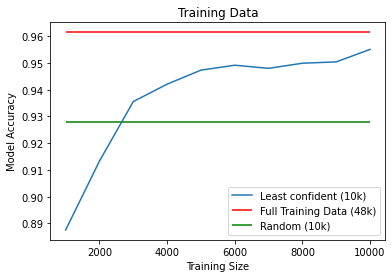

In [ ]:
import matplotlib.pyplot as plt
plt.title("Training Data")
plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.hlines(y=random_10k_training_score, xmin=1000, xmax=10000, color = 'g', label = "Random (10k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [ ]:
optimize_train = OptimizeTrain(clfs = [MLPClassifier(hidden_layer_sizes=(100), activation='relu', random_state=0), MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), activation='relu', random_state=0)])
optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full)

Training complete in  1m47s
Training complete in  2m52s


{MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), random_state=0): {1000: 0.7375,
  2000: 0.8265833333333333,
  3000: 0.8696666666666667,
  4000: 0.8915,
  5000: 0.9015,
  6000: 0.9153333333333333,
  7000: 0.93125,
  8000: 0.9358333333333333,
  9000: 0.9365,
  10000: 0.9400833333333334},
 MLPClassifier(hidden_layer_sizes=100, random_state=0): {1000: 0.8035,
  2000: 0.8599166666666667,
  3000: 0.8860833333333333,
  4000: 0.90575,
  5000: 0.916,
  6000: 0.9264166666666667,
  7000: 0.9325833333333333,
  8000: 0.9341666666666667,
  9000: 0.9361666666666667,
  10000: 0.9500833333333333}}

In [ ]:
optimize_train = OptimizeTrain()
least_confident_samples_results_2 = optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full, training_size = 20000, step_size = 2000)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training complete in  8m20s


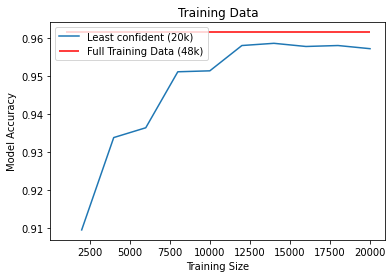

In [ ]:
import matplotlib.pyplot as plt
plt.title("Training Data")
plt.hlines(y=full_training_score, xmin=1000, xmax=20000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results_2.keys()), list(least_confident_samples_results_2.values()), label = "Least confident (20k)")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

Stepping through and systematically adding training data the model is least confident in yields a model with comparable accuracy to that of the full training set with only a fraction of the training data. Beyond a training size of about 10k, the accuracy plateaus.

#Different methods of measuring the model's confidence on a training sample.


clf.predict_proba returns an array with the probabity for each possible label (1-10 in this case)

*   Maximum proba
*   Standard deviation
*   Difference in top two


In [ ]:
optimize_train = OptimizeTrain()
cm_max_proba_results = least_confident_samples_results
cm_std_results = optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full, confidence_measure = "std")
cm_top_two_results = optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full, confidence_measure = "top_two")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training complete in  4m40s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training complete in  5m 8s


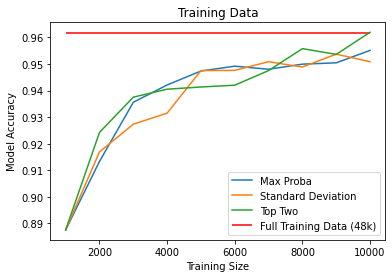

In [ ]:
import matplotlib.pyplot as plt
plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(cm_max_proba_results.keys()), list(cm_max_proba_results.values()), label = "Max Proba")
plt.plot(list(cm_std_results.keys()), list(cm_std_results.values()), label = "Standard Deviation")
plt.plot(list(cm_top_two_results.keys()), list(cm_top_two_results.values()), label = "Top Two")
plt.title("Training Data")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

While this graph is still relatively clear, heat maps can be a great way to represent lots of data.

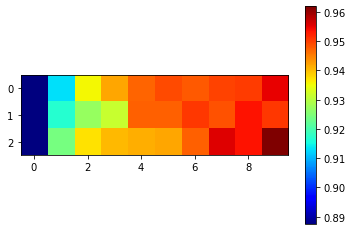

Key: (0: Max Proba) (1: Standard Deviation) (2: Top Two)


In [ ]:
result_table = np.array([list(cm_max_proba_results.values()), list(cm_std_results.values()), list(cm_top_two_results.values())])
plt.imshow(result_table, cmap = 'jet')
plt.colorbar()
plt.show()
print("Key: (0: Max Proba) (1: Standard Deviation) (2: Top Two)")

All three methods of measuring confidence are comparable.

#Different step sizes
The amount of new least confident training data added and retrained on at each step.

In [ ]:
optimize_train = OptimizeTrain()
step_sizes = [2000, 1000, 500, 200, 100]

step_size_results_dict = {}

for step_size in step_sizes:
  print(str(step_size) + ": ", end = "\t")
  step_size_results_dict[step_size] = optimize_train.train_and_score(x_train_full, y_train_full, x_test_full, y_test_full, step_size = step_size)

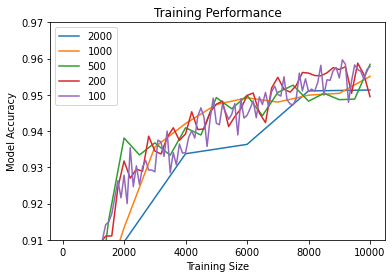

In [ ]:
import matplotlib.pyplot as plt

for step_size in step_size_results_dict.keys():
  results_dict = step_size_results_dict[step_size]
  plt.plot(list(results_dict.keys()), list(results_dict.values()), label = step_size)

plt.ylim(0.91, 0.97)
plt.title("Training Data")
plt.title("Training Performance")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [ ]:
def showHeatMap(results_dict_dict, step_size = 1000, full_size = 10000): #assumes first index is at step_size
  results_table = []
  results_dict_list = list(results_dict_dict.values())

  iterations = int(full_size / step_size)

  for results_dict in results_dict_list:
    row = list()
    for i in range(iterations):
      key = (i + 1) * step_size
      if key in results_dict.keys():
        row.append(results_dict[key])
      elif len(row) > 0:
        row.append(row[-1])
      else:
        row.append(0)
    results_table.append(row)


  plt.imshow(np.array(results_table), cmap = 'jet')
  plt.colorbar()
  plt.show()

  print("Key: ", end="")
  for i in range(len(results_dict_dict.keys())):
    print("(" + str(i) + ": " + str(list(results_dict_dict.keys())[i]), end=") ")


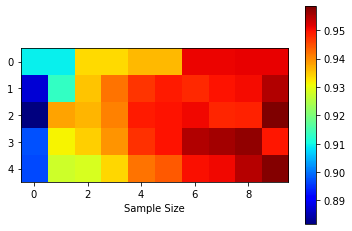

Key: (0: 2000) (1: 1000) (2: 500) (3: 200) (4: 100) 

In [ ]:
results_table = []
results_dict_list = list(step_size_results_dict.values())

for results_dict in results_dict_list:
  row = list()
  for i in range(10):
    key = i * 1000 + 1000
    if key in results_dict.keys():
      row.append(results_dict[key])
    else:
      row.append(results_dict[key+1000])
  results_table.append(row)


plt.imshow(np.array(results_table), cmap = 'jet')
plt.colorbar()
plt.title("")
plt.xlabel("Sample Size")
# plt.xticks(np.arange(1000, 11000, 1000))
# plt.gca().set_xticks(np.arange(1000, 11000, 1000))
# plt.ylabel("See Key")
plt.show()

print("Key: ", end="")
for i in range(len(step_size_results_dict.keys())):
  print("(" + str(i) + ": " + str(list(step_size_results_dict.keys())[i]), end=") ")

#Dimensionality reduction through principal component anaysis

The more features our data has, the more data we need to train it. PCA can remove insignificant features from our entire dataset,

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 24, random_state = 0)
compressed = pca.fit_transform(data)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(compressed, labels, train_size = 0.80, random_state=0)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (100, 100), activation = "logistic", random_state = 0)
clf.fit(x_train_pca, y_train_pca)

pca_full_training = clf.score(x_test_pca, y_test_pca)
print(pca_full_training)

0.96375


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
print(pca_full_training)

0.96375


Training on the full training set with only 24 features (instead of 784) yields a better model accuracy.

In [ ]:
n_components_list = [8, 16, 32, 64, 128, 256, 512, 12, 24, 49, 98, 196, 392, 784]
optimize_train = OptimizeTrain()
pca_n_components_results_dict = {}

for n_components in n_components_list:
  pca = PCA(n_components = n_components, random_state = 0)
  compressed = pca.fit_transform(data)
  x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(compressed, labels, train_size = 0.80, random_state=0)
  pca_n_components_results_dict[n_components] = optimize_train.train_and_score(x_train_pca, y_train_pca, x_test_pca, y_test_pca)


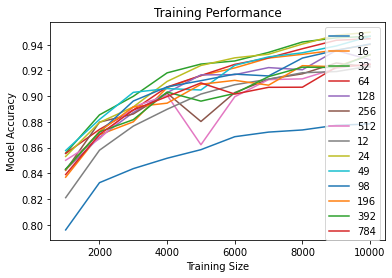

In [ ]:
import matplotlib.pyplot as plt

for n_components in pca_n_components_results_dict.keys():
  results_dict = pca_n_components_results_dict[n_components]
  plt.plot(list(results_dict.keys()), list(results_dict.values()), label = n_components)

# plt.ylim(0.91, 0.97)
plt.title("Training Data")
plt.title("Training Performance")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

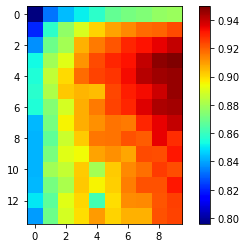

Key: (0: 8) (1: 12) (2: 16) (3: 24) (4: 32) (5: 49) (6: 64) (7: 98) (8: 128) (9: 196) (10: 256) (11: 392) (12: 512) (13: 784) 

In [ ]:
showHeatMap(pca_n_components_results_dict, 1000, 10000)

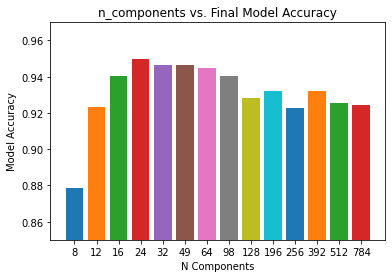

In [ ]:
import matplotlib.pyplot as plt
import collections

pca_final_accuracy = {}

pca_n_components_results_dict = collections.OrderedDict(sorted(pca_n_components_results_dict.items()))

for n_components in pca_n_components_results_dict.keys():
  # print(list(pca_n_components_results_dict[n_components].values())[-1])
  # plt.plot(n_components, list(pca_n_components_results_dict[n_components].values())[-1])
  plt.bar(str(n_components), list(pca_n_components_results_dict[n_components].values())[-1])

plt.title("n_components vs. Final Model Accuracy")
plt.xlabel("N Components")
plt.ylabel("Model Accuracy")
plt.ylim(0.85, 0.97)
# plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
optimize_train = OptimizeTrain()

pca = PCA(n_components = 24, random_state = 0)
compressed = pca.fit_transform(data)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(compressed, labels, train_size = 0.80, random_state=0)
pca_24_results_dict = optimize_train.train_and_score(x_train_pca, y_train_pca, x_test_pca, y_test_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  3m33s


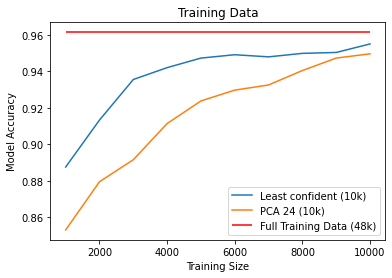

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(pca_24_results_dict.keys()), list(pca_24_results_dict.values()), label = "PCA 24 (10k)")
plt.title("Training Data")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

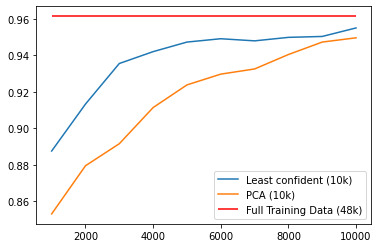

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(pca_24_results_dict.keys()), list(pca_24_results_dict.values()), label = "PCA (10k)")
plt.title("Training Data")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

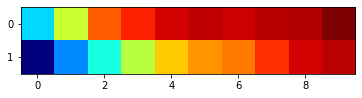

In [ ]:
plt.imshow(np.array([list(least_confident_samples_results.values()), list(pca_24_results_dict.values())]), cmap = 'jet')

In [ ]:
np.array([list(least_confident_samples_results.values()), list(pca_24_results_dict.values())])

array([[0.88758333, 0.91333333, 0.93558333, 0.94208333, 0.94733333,
        0.94916667, 0.948     , 0.94991667, 0.95041667, 0.95508333],
       [0.85308333, 0.8795    , 0.89158333, 0.91141667, 0.92383333,
        0.92975   , 0.93258333, 0.9405    , 0.94733333, 0.94966667]])

Reached comparable accuracy and trained faster (5m13s vs 3m35s). Unfortunately, PCA doesn't seem be able to surpass accuracy of traing with all the features.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=8)
compressed = lda.fit_transform(data, labels)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_lda, x_test_lda, y_train_lda, y_test_lda = train_test_split(compressed, labels, train_size = 0.80, random_state=0)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (100, 100), activation = "logistic", random_state = 0)
clf.fit(x_train_lda, y_train_lda)

lda_full_training = clf.score(x_test_lda, y_test_lda)
print(lda_full_training)

0.9254166666666667


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
optimize_train = OptimizeTrain()
lda_results_dict = optimize_train.train_and_score(x_train_lda, y_train_lda, x_test_lda, y_test_lda)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  3m59s


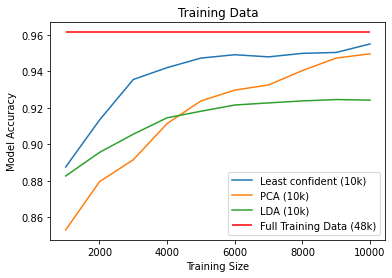

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(pca_24_results_dict.keys()), list(pca_24_results_dict.values()), label = "PCA (10k)")
plt.plot(list(lda_results_dict.keys()), list(lda_results_dict.values()), label = "LDA (10k)")
plt.title("Training Data")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

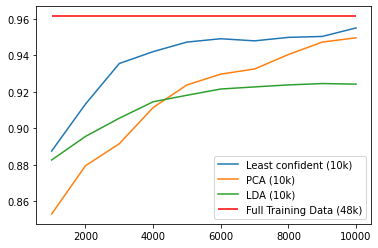

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(pca_24_results_dict.keys()), list(pca_24_results_dict.values()), label = "PCA (10k)")
plt.plot(list(lda_results_dict.keys()), list(lda_results_dict.values()), label = "LDA (10k)")
plt.legend()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

tsne = TSNE(n_components=2, verbose=1, random_state=0)

compressed = tsne.fit_transform(data, labels)

x_train_tsne, x_test_tsne, y_train_tsne, y_test_tsne = train_test_split(compressed, labels, train_size = 0.80, random_state=0)

clf = MLPClassifier(hidden_layer_sizes = (100, 100), activation = "logistic", random_state = 0)
clf.fit(x_train_tsne, y_train_tsne)

tsne_full_training = clf.score(x_test_tsne, y_test_tsne)
print(tsne_full_training)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.050s...
[t-SNE] Computed neighbors for 60000 samples in 259.191s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
optimize_train = OptimizeTrain()
tsne_results_dict = optimize_train.train_and_score(x_train_tsne, y_train_tsne, x_test_tsne, y_test_tsne)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  2m20s


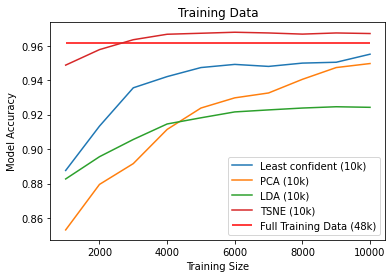

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'r', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(pca_24_results_dict.keys()), list(pca_24_results_dict.values()), label = "PCA (10k)")
plt.plot(list(lda_results_dict.keys()), list(lda_results_dict.values()), label = "LDA (10k)")
plt.plot(list(tsne_results_dict.keys()), list(tsne_results_dict.values()), label = "TSNE (10k)")
plt.title("Training Data")
plt.xlabel("Training Size")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

t-distributed Stochastic Neighbourhood Embedding (TSNE) dimensionality reduction is able to reduce our features and training time (2m28s), and surpasses the full training data accuracy with less than 4k training data!

In [ ]:
optimize_train = OptimizeTrain()
confidence_measures = ["max_proba", "std", "top_two"]
step_sizes = [2000, 1000, 500, 100]

tsne_results_dict = {}

for confidence_measure in confidence_measures:
  for step_size in step_sizes:
    tsne_results_dict[(confidence_measure, step_size)] = optimize_train.train_and_score(x_train_tsne, y_train_tsne, x_test_tsne, y_test_tsne, confidence_measure = confidence_measure, step_size = step_size)

(0.85, 0.98)

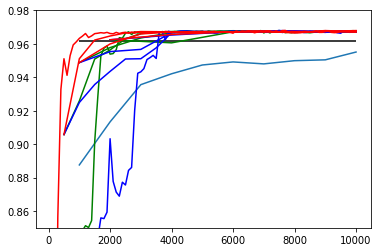

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=1000, xmax=10000, color = 'black', label = "Full Training Data (48k)")
plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")

colors = {'max_proba': 'green', 'std': 'blue', 'top_two': 'red'}

for key in tsne_results_dict:
  results_dict = tsne_results_dict[key]
  plt.plot(list(results_dict.keys()), list(results_dict.values()), color = colors[key[0]])

plt.ylim(0.85, 0.98)

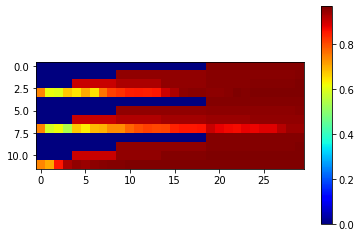

Key: (0: ('max_proba', 2000)) (1: ('max_proba', 1000)) (2: ('max_proba', 500)) (3: ('max_proba', 100)) (4: ('std', 2000)) (5: ('std', 1000)) (6: ('std', 500)) (7: ('std', 100)) (8: ('top_two', 2000)) (9: ('top_two', 1000)) (10: ('top_two', 500)) (11: ('top_two', 100)) 

In [ ]:
showHeatMap(tsne_results_dict, 100, 3000)

Smaller step sizes here with top two confidence measuring are promising, achieving peak accuracy in around 1k samples.

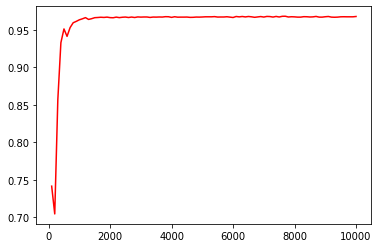

In [ ]:
results_dict = tsne_results_dict[('top_two', 100)]
plt.plot(list(results_dict.keys()), list(results_dict.values()), color = colors[key[0]])
plt.ylim()

In [ ]:
optimize_train = OptimizeTrain()

tsne_2k_results = optimize_train.train_and_score(x_train_tsne, y_train_tsne, x_test_tsne, y_test_tsne, confidence_measure="top_two", step_size=10, training_size=1000)

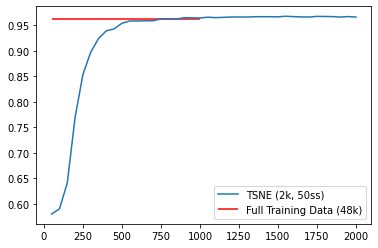

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=50, xmax=2000, color = 'r', label = "Full Training Data (48k)")
# plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(tsne_2k_results.keys()), list(tsne_2k_results.values()), label = "TSNE (2k, 50ss)")
plt.legend()

In [ ]:
optimize_train = OptimizeTrain()

tsne_1k_results = optimize_train.train_and_score(x_train_tsne, y_train_tsne, x_test_tsne, y_test_tsne, confidence_measure="top_two", step_size=50, training_size=600)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  0m16s


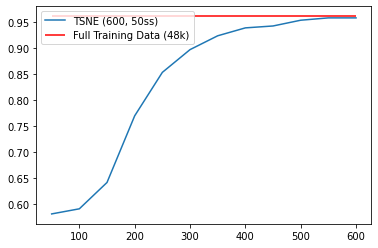

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=50, xmax=600, color = 'r', label = "Full Training Data (48k)")
# plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(tsne_1k_results.keys()), list(tsne_1k_results.values()), label = "TSNE (600, 50ss)")
plt.legend()

In [ ]:
x_train_tsne.shape

(48000, 2)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

tsne2 = TSNE(n_components=3, verbose=1, random_state=0)

compressed = tsne2.fit_transform(data, labels)

x_train_tsne2, x_test_tsne2, y_train_tsne2, y_test_tsne2 = train_test_split(compressed, labels, train_size = 0.80, random_state=0)

clf = MLPClassifier(hidden_layer_sizes = (100, 100), activation = "logistic", random_state = 0)
clf.fit(x_train_tsne2, y_train_tsne2)

print(clf.score(x_test_tsne2, y_test_tsne2))

In [ ]:
optimize_train = OptimizeTrain()

tsne2_results = optimize_train.train_and_score(x_train_tsne2, y_train_tsne2, x_test_tsne2, y_test_tsne2, confidence_measure="top_two", step_size=50, training_size=450)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  0m12s


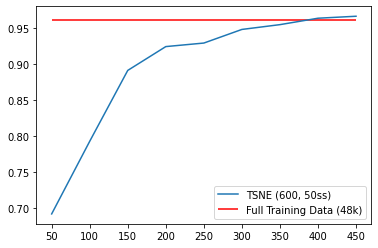

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=50, xmax=450, color = 'r', label = "Full Training Data (48k)")
# plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(tsne2_results.keys()), list(tsne2_results.values()), label = "TSNE (600, 50ss)")
plt.legend()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

tsne3 = TSNE(n_components=1, verbose=1, random_state=0)

compressed = tsne3.fit_transform(data, labels)

x_train_tsne3, x_test_tsne3, y_train_tsne3, y_test_tsne3 = train_test_split(compressed, labels, train_size = 0.80, random_state=0)

clf = MLPClassifier(hidden_layer_sizes = (100, 100), activation = "logistic", random_state = 0)
clf.fit(x_train_tsne3, y_train_tsne3)

print(clf.score(x_test_tsne3, y_test_tsne3))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.068s...
[t-SNE] Computed neighbors for 60000 samples in 250.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

In [ ]:
optimize_train = OptimizeTrain()

tsne_results_dict = optimize_train.train_and_score(x_train_tsne, y_train_tsne, x_test_tsne, y_test_tsne, training_size = 450, step_size = 10)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Training complete in  1m 6s


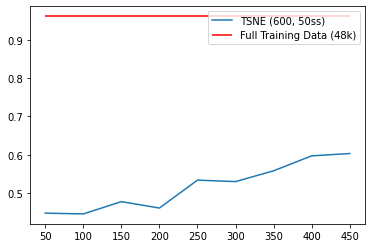

In [ ]:
import matplotlib.pyplot as plt

plt.hlines(y=full_training_score, xmin=50, xmax=450, color = 'r', label = "Full Training Data (48k)")
# plt.plot(list(least_confident_samples_results.keys()), list(least_confident_samples_results.values()), label = "Least confident (10k)")
plt.plot(list(tsne3_results.keys()), list(tsne3_results.values()), label = "TSNE (600, 50ss)")
plt.legend()